# Using NLP techniques to segement customers based on review data. 

### Table of Contents 

- [Import Packages](#Import-Packages)
- [Import Data](#Import-Data)
- [Data Cleaning](#Data-Cleaning)
- [Data Processing](#Data-Processing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [LDA Modeling](#LDA-Modeling)
- [Model Interpretation](#Model-Interpretation)
- [Limitations](#Limitations)
- [Conclusion & Recommendations](#Conclusion-&-Recommendations)
- [Sources](#Sources) 


### Problem Statement 

"Apparel and accessories represented 29% of Amazon’s retail e-commerce sales in the U.S. last year, generating $35.79 billion, according to research firm eMarketer." (Lee, 2019)

Amazon is looking to expand it's share of the fashion business. Amazon Fashion recently begun a series of limited-edition influencer-designed collections called The Drop. The collections drop every Thursday and are available for purchase for only 30 hours, making the pieces extra exclusive. In even simplier ways, on the Amazon Fashion home page, they highlighting links to lists of items that have over a certain threshold of reviewers as, 'Customer's most loved styles'. Once you navigate to that page, they've even taken this up a step further with different product categories and influencer's reviews of popular products. Later this month, Amazon Prime is releasing "Making The Cut" a fashion-based reality TV show with Heidi Klum and Tim Gunn, of Project Runway fame. The premise of the show is designers will compete to launch an new brand and a 1 million dollar prize. The winning designs will then be available to shop on Amazon Fashion immediately afterwards. 

Working with data made available from researchers at UCSD, we will process the text of reviews using NLP techniques and then use unsupervised learning techniques to make clusters. The model will be evaluated on it's Silhouette Score.  From there we'll do EDA on these different clusters to figure out which segementation of the market they are and provide insights on how they should be targeted.

### Data Dictionary 

|Feature|Type|Description|
|---|---|---|
|reviewerID|Object|ID of the reviewer.|
|asin|Object| ID of the product.|
|reviewText| Object |text of the review|
|summary |Object |summary of the review |
|unixReviewTime |Integer| time of the review (unix time) |



### Import Packages

In [65]:
import os
import json
import gzip
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.style as style 
from matplotlib.ticker import MaxNLocator
import missingno as msno 
from urllib.request import urlopen
import regex as re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim

### Import Data 

The data is broken into 2 datasets, the first which we'll spend the majority of our time working with is the reviews dataset with a total of 883,636 rows. We'll also load and clean the metadata, which has more information about the products being reviewed. 

In [2]:
# reading in Amazon Fashion review data 
data = []
with gzip.open('./data/AMAZON_FASHION.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])


883636
{'overall': 5.0, 'verified': True, 'reviewTime': '10 20, 2014', 'reviewerID': 'A1D4G1SNUZWQOT', 'asin': '7106116521', 'reviewerName': 'Tracy', 'reviewText': 'Exactly what I needed.', 'summary': 'perfect replacements!!', 'unixReviewTime': 1413763200}


In [3]:
# convert list into pandas DataFrame
df = pd.DataFrame.from_dict(data)
print(len(df))

883636


In [4]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN
2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN
3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN
4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN


In [5]:
df.shape

(883636, 12)

Next, we'll read in the Metadata which contains the product information. 

In [6]:
# this dataset includes a notebook which walks you through additional data cleaning, this is pulled from that 
# https://colab.research.google.com/drive/1Zv6MARGQcrBbLHyjPVVMZVnRWsRnVMpV#scrollTo=LgWrDtZ94w89
asin_data = []
with gzip.open('./data/meta_AMAZON_FASHION.json.gz') as f:
    for l in f:
        asin_data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(asin_data))

# first row of the list
print(asin_data[0])

186637
{'title': 'Slime Time Fall Fest [With CDROM and Collector Cards and Neutron Balls, Incredi-Ball and Glow Stick Necklace, Paper Fram', 'image': ['https://images-na.ssl-images-amazon.com/images/I/51bSrINiWpL._US40_.jpg'], 'brand': 'Group Publishing (CO)', 'feature': ['Product Dimensions:\n                    \n8.7 x 3.6 x 11.4 inches', 'Shipping Weight:\n                    \n2.4 pounds'], 'rank': '13,052,976inClothing,Shoesamp;Jewelry(', 'date': '8.70 inches', 'asin': '0764443682'}


In [7]:
asin_df = pd.DataFrame.from_dict(asin_data)
print(len(asin_df))

186637


In [8]:
# this dataset includes a notebook which walks you through additional data cleaning
# https://colab.research.google.com/drive/1Zv6MARGQcrBbLHyjPVVMZVnRWsRnVMpV#scrollTo=LgWrDtZ94w89
# remove rows with unformatted title (i.e. some 'title' may still contain html style content)
df3 = asin_df.fillna('')
df4 = df3[df3.title.str.contains('getTime')] # unformatted rows
product_df = df3[~df3.title.str.contains('getTime')] # filter those unformatted rows
print(len(df4))
print(len(product_df))

430
186207


In [9]:
product_df.head()

,title,image,brand,feature,rank,date,asin,description,price,also_view,also_buy,fit,details,similar_item,tech1
0,Slime Time Fall Fest [With CDROM and Collector...,[https://images-na.ssl-images-amazon.com/image...,Group Publishing (CO),[Product Dimensions:\n \n8....,"13,052,976inClothing,Shoesamp;Jewelry(",8.70 inches,0764443682,,,,,,,,
1,XCC Qi promise new spider snake preparing men'...,[https://images-na.ssl-images-amazon.com/image...,,,"11,654,581inClothing,Shoesamp;Jewelry(",5 star,1291691480,,,,,,,,
2,Magical Things I Really Do Do Too!,[https://images-na.ssl-images-amazon.com/image...,Christopher Manos,[Package Dimensions:\n \n8....,"19,308,073inClothing,ShoesJewelry(",5 star,1940280001,[For the professional or amateur magician. Ro...,,,,,,,
3,"Ashes to Ashes, Oranges to Oranges",[https://images-na.ssl-images-amazon.com/image...,Flickerlamp Publishing,[Package Dimensions:\n \n8....,"19,734,184inClothing,ShoesJewelry(",5 star,1940735033,,,,,,,,
4,Aether & Empire #1 - 2016 First Printing Comic...,[https://images-na.ssl-images-amazon.com/image...,,[Package Dimensions:\n \n10...,"10,558,646inClothing,Shoesamp;Jewelry(",5 star,1940967805,,$4.50,,,,,,


In [10]:
product_df.shape

(186207, 15)

### Data Cleaning

First we'll check out how many missing values we've got. 

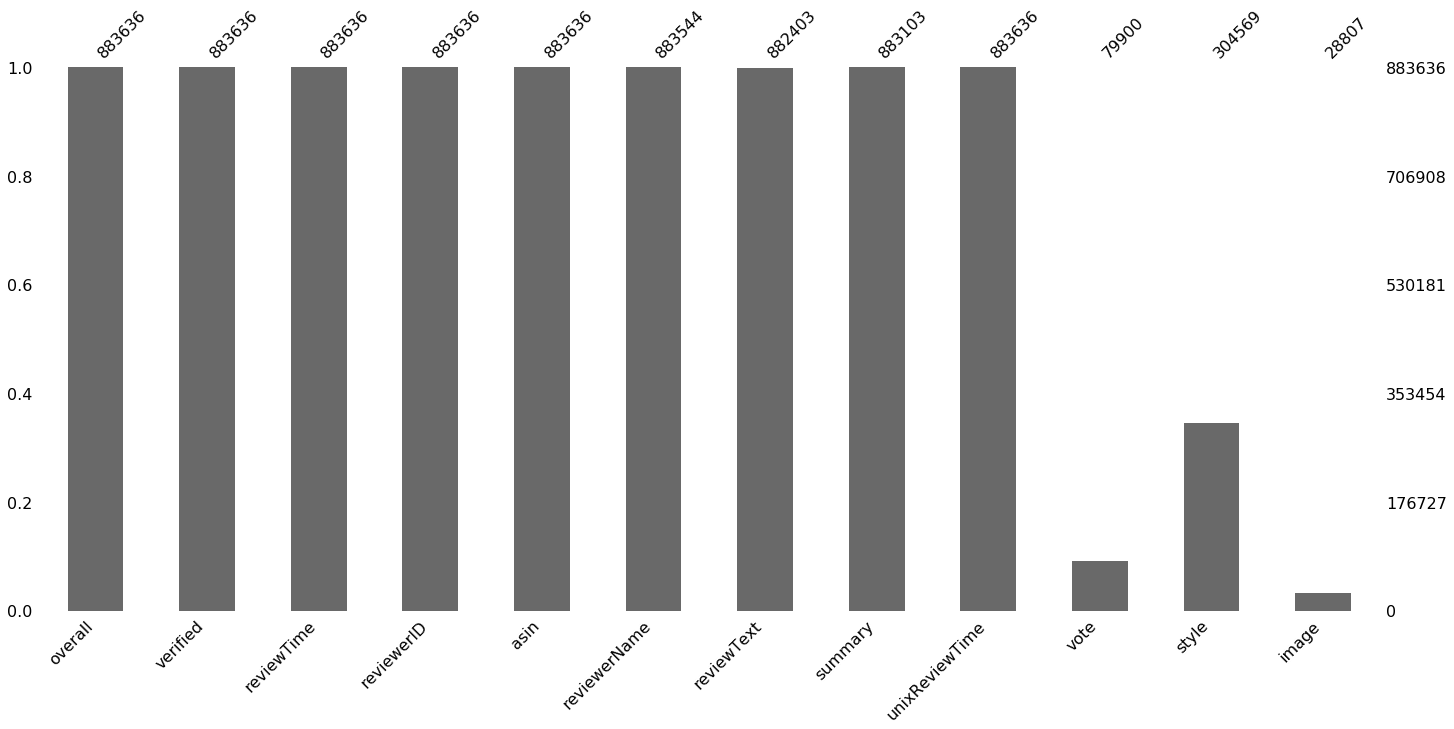

In [13]:
#plot nulls quickly 
msno.bar(df) 

In [14]:
df.isnull().sum()

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          92
reviewText          1233
summary              533
unixReviewTime         0
vote              803736
style             579067
image             854829
dtype: int64

**Oberservation:** There appears to be a large amount of missing data in the `vote`, `style`, and `image` columns, so we'll drop those. We will also drop the `reviewerName` column since  it is a reduntancy of the `reviewerID` column. I'm also dropping the `overall`, `verified`, and the `reviewTime` columns to condense the DataFrame.  I will also drop any rows that are missing the `reviewText` column, as that is what I'm planning on feeding into the LDA model. 

In [15]:
# dropping columns 
df.drop(columns = ['vote', 'style', 'image',
                   'reviewerName', 'overall',
                   'verified', 'reviewTime'],
                    inplace = True)

In [16]:
# dropping rows
df.dropna( axis = 0 , subset = ['reviewText'], inplace = True)

In [17]:
# new shape? 
df.shape

(882403, 5)

In [19]:
# call .head()
df.head()

,reviewerID,asin,reviewText,summary,unixReviewTime
0,A1D4G1SNUZWQOT,7106116521,Exactly what I needed.,perfect replacements!!,1413763200
1,A3DDWDH9PX2YX2,7106116521,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400
2,A2MWC41EW7XL15,7106116521,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800
3,A2UH2QQ275NV45,7106116521,too tiny an opening,Two Stars,1408838400
4,A89F3LQADZBS5,7106116521,Okay,Three Stars,1406419200


In [ ]:
# call .info()
df.info()

Next, we'll need to deal with the fact that the reviewerID and asin columns are not in the proper format. 

In [20]:
# using hash to update reviewerID column. found help on how to do this on stackoverflow. 
# https://stackoverflow.com/questions/56579642/convert-unique-string-ids-to-unique-integer-ids-in-python
df['int_reviewerID'] = [hash(uid) for uid in df['reviewerID']]
# also updating the asin column to int with the hash 
df['int_asin'] = [hash(uasin) for uasin in df['asin']]

In [21]:
df.head()

,reviewerID,asin,reviewText,summary,unixReviewTime,int_reviewerID,int_asin
0,A1D4G1SNUZWQOT,7106116521,Exactly what I needed.,perfect replacements!!,1413763200,-2344922558037732583,-8128986198600547651
1,A3DDWDH9PX2YX2,7106116521,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,2353989269516341071,-8128986198600547651
2,A2MWC41EW7XL15,7106116521,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,3771528891396838068,-8128986198600547651
3,A2UH2QQ275NV45,7106116521,too tiny an opening,Two Stars,1408838400,-1840322997657341031,-8128986198600547651
4,A89F3LQADZBS5,7106116521,Okay,Three Stars,1406419200,2344972052199776474,-8128986198600547651


I'm going to keep the original columns as the 'asin' can be used to reference which items it represents in the product_df. 

### Exploratory Data Analysis 

In [22]:
df['int_reviewerID'].value_counts()

 5516510784247952705    40
-5439841496349137691    36
 2178350922417672234    32
 5778962767597237065    31
-5109896908434236308    29
                        ..
 8398123453649335266     1
 2759754697695507174     1
 2354352156653979308     1
 1812661208835207970     1
 4668399934490318469     1
Name: int_reviewerID, Length: 748219, dtype: int64

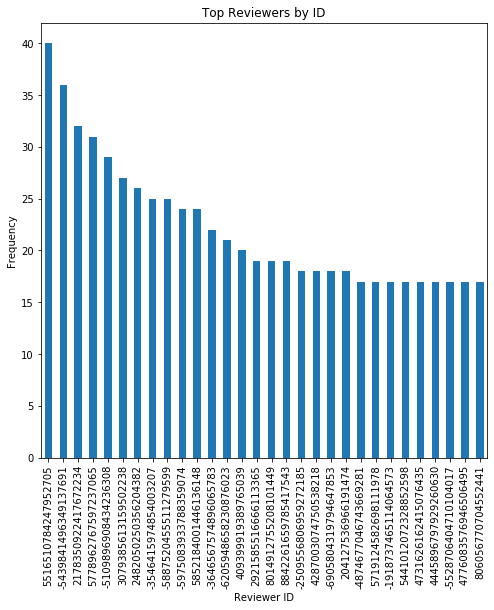

In [23]:
plt.figure(figsize = (8, 8))
plt.title("Top Reviewers by ID")
plt.xlabel('Reviewer ID')
plt.xticks(rotation= 90)
plt.ylabel('Frequency')
df['int_reviewerID'].value_counts()[:30].plot(kind = 'bar');

In [24]:
df['asin'].value_counts()

B000V0IBDM    4380
B000KPIHQ4    4371
B00I0VHS10    3884
B00RLSCLJM    3633
B000PHANNM    2566
              ... 
B016MHVKAI       1
B00KKZVER8       1
B00IGL2RUG       1
B01138AR4G       1
B01GU5JJP0       1
Name: asin, Length: 186112, dtype: int64

In [25]:
what_is_its = (product_df['asin'] == 'B000P0X15G')
product_df[what_is_its]

,title,image,brand,feature,rank,date,asin,description,price,also_view,also_buy,fit,details,similar_item,tech1
3315,"i play. Girls' Baby Brim Sun Protection Hat, A...",[https://images-na.ssl-images-amazon.com/image...,i play.,[Shipping Information:\n \n...,,5 star5 star (0%),B000P0X15G,,$7.99 - $18.38,,,"class=""a-normal a-align-center a-spacing-smal...",,,


Using the `asin` through the Product DataFrame, these are the 20 items with the most reviews. 

|`asin` |Number of Reviews| Product Name / title|
|---|---|---|
|B000V0IBDM| 4380 |Powerstep Pinnacle Orthotic Shoe Insoles|
|B000KPIHQ4|4371 |Powerstep Pinnacle Orthotic Shoe Insoles |
|B00I0VHS10|3884|90 Degree By Reflex Power Flex Yoga Capri | 
|B00RLSCLJM|3633|MJ Metals Jewelry 2mm to 10mm White Tungsten Carbide Mirror Polished Classic Wedding Ring | 
|B000PHANNM|2566 |i play. Baby Boys Flap Sun Protection Hat|
|B000YFSR5G|2534 |Hanes Mens EcoSmart Fleece Sweatpant|
|B00201ER88|2202|i play. by green sprouts Baby & Toddler Brim Sun Protection Hat |
|B00GXE331K|2025|Best RFID Blocking Card Holder Case for Men|
|B000P0X15G|1924|i play. Girls' Baby Brim Sun Protection Hat|
|B00XT15P8E|1855|Marino Avenue Men’s Genuine Leather Ratchet Dress Belt|
|B0017U1KBK|1826|Totes Kids Bubble Umbrella|
|B005N7YWX6|1688|Ingrid & Isabel Women's Maternity Everyday Bellaband|
|B004HX6P1E|1671|BodyJ4You 50PC Tongue Barbells Nipple Rings 14G Mix Acrylic Ball Steel Flexible Piercing Jewelry|
|B000YFSR4W|1648|Hanes Mens EcoSmart Fleece Sweatpant|
|B009RUKQ2G|1590|Scarleton Large Satchel H106801 - Black|
|B000JOOR7O|1584|Vans Adult Classic Slip-On, (Checkerboard)|
|B00ZW3SCF0|1522|Womens Crop Top Midi Skirt Outfit Two Piece Bodycon Bandage Dress|
|B000GHRZN2|1415|Carhartt Men's Loose Fit Five Pocket Canvas Carpenter Jean|
|B000GHMRLW|1415|Carhartt Men's Loose Fit Five Pocket CanvasCarpenter Jean|
|B00XTM0ZPG|1405|WearMe Pro - Classic Half Frame Polarized Sunglasses|

From examining the most frequently occuring `asin` we can see there is both Men's, Women's and Children's clothing products listed under the umbrella of Amazon Fashion. The dataset also includes items that are a little more broad, including shoe insoles, accessories, etc but still within the ready-to-wear category. 

In [ ]:
plt.figure(figsize = (8, 8))
plt.title("Top Items purchased")
plt.xlabel('Asin')
plt.xticks(rotation= 90)
plt.ylabel('Frequency')
df['asin'].value_counts()[:30].plot(kind = 'bar');

### Data Processing 

From here let's move into processing the `ReviewText` column to prep for LDA modeling.

In [26]:
# We'll begin by lowercasing the reveiwText column
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x.lower() for x in x.split()))
# Then we'll remove any non-letters
df['reviewText'] =df['reviewText'].str.replace('[^\w\s]','')
df['reviewText'].head()

0                                exactly what i needed
1    i agree with the other review the opening is t...
2    love these i am going to order another pack to...
3                                  too tiny an opening
4                                                 okay
Name: reviewText, dtype: object

In [ ]:
# Next, we'll work on expanding the contradictions 
# I used this article on stack over flow for help with expanding contractions. 
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions_dict = { 
        "ain't": "am not ",
        "aren't": "are not / am not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would", 
        "he'll": "he will",
        "he's": " he is",
        "how'd": "how did",
        "how'll": "how will",
        "how's": "how is ",
        "I'd": "I would",
        "I'll": "I will",
        "I'm": "I am",
        "I've": "I have",
        "isn't": "is not",
        "it'd": "it would",
        "it'll": " it will",
        "it's": "it has / it is",
        "let's": "let us",
        "ma'am": "madam",
        "might've": "might have",
        "mightn't": "might not",
        "must've": "must have",
        "mustn't": "must not",
        "needn't": "need not",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "so've": "so have",
        "so's": "so is",
        "that'd": "that would",
        "that's": "that is",
        "there'd": "there would",
        "there's": "there is",
        "they'd": "they would",
        "they'll": "they will",
        "they're": "they are",
        "they've": "they have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'll": "we will",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who's": " who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "would've": "would have",
        "wouldn't": "would not",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you're": "you are",
        "you've": "you have",
}
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

In [27]:
# creating functions to replace the contractions found with their expansion
def replace(match): 
    return contract_dict[match.group(0)]\

def expand_contractions(s , contractions_dict=contractions_dict):
    return contractions_re.sub(replace, s)

In [28]:
# apply function 
df['reviewText'] = [expand_contractions(s, contractions_dict=contractions_dict) for s in df['reviewText']]
df['reviewText'].head()

0                                exactly what i needed
1    i agree with the other review the opening is t...
2    love these i am going to order another pack to...
3                                  too tiny an opening
4                                                 okay
Name: reviewText, dtype: object

From there explore Lemmitization and Steming of texts then be ready for modeling. Need to go back and comment out code, set datetime column to proper date/time index just incase we end up needing, Problem Statement/ intro to project --continue to flush out, 


EDA on text reviews 
Models to try - DBSCAN, LDA clustering, 
Evaluate models 
Evaluate coefficients 
EDA on clusters
Model limitations 
Conclusion and Recommendations 


The next steps for preprocessing for our gensim LDA model is to tokenize the data, then lemmatize, remove stopwords, create bigrams to prepare our dictionary. 

In [29]:
# getting the reviewText values to list 
data = df.reviewText.values.tolist()

# Split the data into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(data)):
    data[idx] = data[idx].lower()  # Convert to lowercase.
    data[idx] = tokenizer.tokenize(data[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
data = [[token for token in text if not token.isnumeric()] for text in data]

# Remove words that are only one character.
data = [[token for token in text if len(token) > 1] for text in data]
print(data[:1])

[['exactly', 'what', 'needed']]


In [30]:
# Next, we'll remove stopwords
# first instanite english stopwords
stop_words = stopwords.words('english')
# Then remove stopwords
data= [[word for word in text if word not in stop_words] for text in data]

Next up is lemmatizing the data. According to the Gensim documentation, lemmatization is prefered over stemming because topic modeling is best preformed on readable words. 

In [31]:
# Lemmatize the documents.
lemmatizer = WordNetLemmatizer()
data = [[lemmatizer.lemmatize(token) for token in text] for text in data]

Next we'll create bigrams and add then to our data. 

In [32]:
# Compute bigrams.
# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(data, min_count=20)
for idx in range(len(data)):
    for token in bigram[data[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            data[idx].append(token)

Finally, we'll create the dictionary, and remove any words that might be outliers. We'll then use that dictionary to create our Corpus.

In [34]:
# Remove rare and common tokens.
# Create a dictionary representation of the documents.
dictionary = Dictionary(data)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [ ]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='20 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['reviewText'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [35]:
#next we'll create our corpus or our bag of words for the data
corpus = [dictionary.doc2bow(text) for text in data]

pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [36]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 14567
Number of documents: 882403


In [37]:
corpus[0]

[(0, 1), (1, 1)]

### LDA Modeling 

From here we'll begin our topic modeling. We'll be using the Gensim Python library to do our modeling. We'll begin by finding the coherence scores for a range of topic numbers to find which number of topics will have the best coherence score. 

In [46]:
# For this section of the project I got help from the book Natural Language Processing Fundamentals (Ghosh & Gunning)
# creating function to calculate cohenerence of the models 
def calculate_coherence_score(documents, dictionary, model): 
    coherence_model = CoherenceModel(model = model,   
                                    texts = documents, 
                                    dictionary = dictionary, 
                                    coherence = 'c_v') #using 'c_v' as my coherence score it's measured 0-1
    return coherence_model.get_coherence()

# then we'll create another function to find coherence scores for a range of topic numbers 
def get_coherence_values(start, stop): 
    for num_topics in range(start, stop):
        print(f'\nCalculating coherence for {num_topics} topics')
        ldamodel = LdaModel(corpus,         # here is where we're instatiating this LDA model, using the corpus we created 
                            num_topics = num_topics,  
                            id2word= dictionary, passes = 2)
        coherence = calculate_coherence_score(data,   # calling the calculate_coherence_score with the data and dictionary we've created
                                              dictionary, 
                                              ldamodel)
        yield coherence   # yeilding that topic number's coherence and looping back through till we finish the range

In [47]:
# setting topic mins and maxs
min_topics, max_topics = 5, 25
# finding the coherence scores for our topics range. 
# commented out because running takes a very long time, I've saved the output to a csv to be read in 
# coherence_scores= list(get_coherence_values(min_topics, max_topics))


Calculating coherence for 5 topics

Calculating coherence for 6 topics

Calculating coherence for 7 topics

Calculating coherence for 8 topics

Calculating coherence for 9 topics

Calculating coherence for 10 topics

Calculating coherence for 11 topics

Calculating coherence for 12 topics

Calculating coherence for 13 topics

Calculating coherence for 14 topics

Calculating coherence for 15 topics

Calculating coherence for 16 topics

Calculating coherence for 17 topics

Calculating coherence for 18 topics

Calculating coherence for 19 topics

Calculating coherence for 20 topics

Calculating coherence for 21 topics

Calculating coherence for 22 topics

Calculating coherence for 23 topics

Calculating coherence for 24 topics


In [55]:
coherence_scores

[0.6052887325658126,
 0.6436348511378424,
 0.6287031874374377,
 0.6511335661187996,
 0.6383258666888769,
 0.6497716604535293,
 0.6205384688980539,
 0.6563728024433816,
 0.6444145617804323,
 0.6553285662792224,
 0.640614073347225,
 0.6390825190088539,
 0.6439562323251978,
 0.643855201244518,
 0.6352223499508338,
 0.6346643474238547,
 0.6393178922700199,
 0.6363239079027919,
 0.61616244449173,
 0.6403446323260247]

In [56]:
import csv

In [59]:
# writting results to CSV 
with open('output.csv','w') as coherence_result_file:
    wr = csv.writer(coherence_result_file, dialect='excel')
    wr.writerow(coherence_scores)

In [62]:
# reading in results via CSV reader 
with open('output.csv', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        print(row)

['0.6052887325658126', '0.6436348511378424', '0.6287031874374377', '0.6511335661187996', '0.6383258666888769', '0.6497716604535293', '0.6205384688980539', '0.6563728024433816', '0.6444145617804323', '0.6553285662792224', '0.640614073347225', '0.6390825190088539', '0.6439562323251978', '0.643855201244518', '0.6352223499508338', '0.6346643474238547', '0.6393178922700199', '0.6363239079027919', '0.61616244449173', '0.6403446323260247']


Now that we've calculated the coherence scores, we'll graph them to find the correct number of topics. 

Text(0.5, 1.0, 'Coherence Scores')

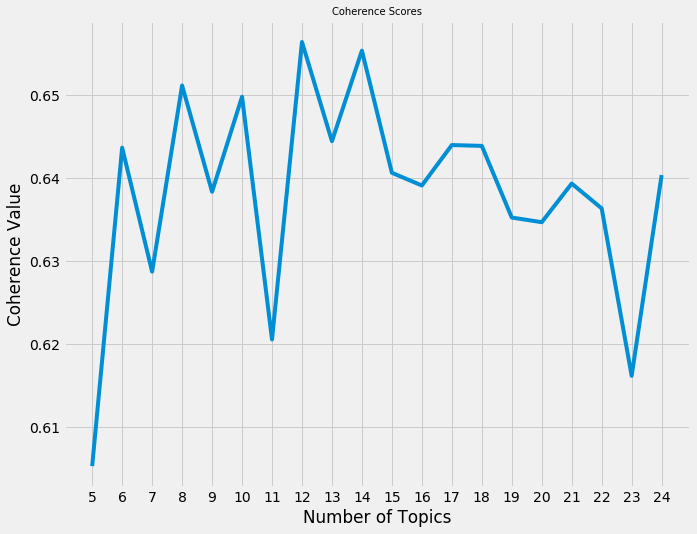

In [52]:
style.use('fivethirtyeight')

x = [int(i) for i in range(min_topics, max_topics)]

ax = plt.figure(figsize =(10, 8))
plt.xticks(x)
plt.plot(x, coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Value')
plt.title('Coherence Scores', fontsize = 10)

From the graph we can see our highest coherence score was at 12 topics. We'll now run that model to interpret the different topics. 

In [63]:
#
ldamodel = LdaModel(corpus,          
                    num_topics = 12,  
                 id2word= dictionary, passes = 2)

ldamodel.save('model.gensim')

In [66]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')

In [67]:
corpus = pickle.load(open('corpus.pkl', 'rb'))


FileNotFoundError: [Errno 2] No such file or directory: 'corpus.pkl'

In [ ]:
lda = LdaModel.load('model.gensim')


In [ ]:
pyLDAvis.display(lda_display)


### Model Interpretation

From there we'll use the pyLDAvis tool to look at the different topics. 

In [ ]:

lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary)

### Limitations 

### Conclusion and Recommendations 

In [ ]:
scale data 
X = df['reviewID', 'asin']
ss= StandardScaler()
X_sc = ss.fit_transform(df)

In [ ]:
Coherence 

then additional modeling 

### Sources 

Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

https://colab.research.google.com/drive/1Zv6MARGQcrBbLHyjPVVMZVnRWsRnVMpV#scrollTo=LgWrDtZ94w89

https://stylecaster.com/amazon-fashion-the-drop-by-you-february-2020/ Bella Gerard 

https://www.latimes.com/entertainment-arts/business/story/2020-02-22/amazon-making-the-cut-reality-tv-heidi-klum-prime
Wendy Lee, Feb 22 2020

https://github.com/marcotav/unsupervised-learning/tree/master/topic-modeling

https://books.google.com/books?id=i8-PDwAAQBAJ&pg=PA164&lpg=PA164&dq=using+nlp+data+and+also+customer+ids+for+clustering&source=bl&ots=J8auw-oehF&sig=ACfU3U3RKK_rHPXi0dH6bQ-le4A9BXSUFw&hl=en&ppis=_c&sa=X&ved=2ahUKEwjg7fLK0ojoAhUtj3IEHSorC7gQ6AEwCXoECA8QAQ#v=onepage&q&f=false


https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28
